In [14]:
#IMPORTING ALL THE REQUIRED PACKAGES.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from subprocess import check_output
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import os
import re
import codecs
import keras
import seaborn as sns
import zipfile
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



In [ ]:
#Download Stuff
nltk.download('stopwords')



In [25]:
if not os.path.isfile('./output.csv'):
    zip_ref = zipfile.ZipFile('./troll-or-not.zip', 'r')
    zip_ref.extractall('./')
    zip_ref.close()
    
if not os.path.isfile('./GoogleNews-vectors-negative300.bin.gz'):
    zip_ref = zipfile.ZipFile('./googles-trained-word2vec-model-in-python.zip', 'r')
    zip_ref.extractall('./')
    zip_ref.close()


In [17]:
stopwords0 = set(stopwords.words('english'))

In [5]:
#SETTING GLOBAL VARIABLES
EMBEDDINGDIM = 300
MAXVOCABSIZE = 175303 
MAXSEQLENGTH = 200 
batchsize = 256 
epochs = 3

In [18]:
#CLEANING UP THE TEXT
#Function to clean up the text

def standardizetext(df, textfield):
    df[textfield] = df[textfield].str.replace(r"http\S+", "LINK")
    df[textfield] = df[textfield].str.replace(r"@\S+", "TAG")
    df[textfield] = df[textfield].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[textfield] = df[textfield].str.replace(r"@", "AT")
    df[textfield] = df[textfield].str.lower()
    return df

In [19]:
df = pd.read_csv('./output.csv',delimiter=',',encoding='utf8',names=["message", "isTroll"])
df.message = df.message.astype(str)

df = df.iloc[:10000]

df = standardizetext(df, "message")
df.head()

,message,isTroll
0,"""we have a sitting democrat us senator on tria...",1
1,marshawn lynch arrives to game in anti trump s...,1
2,daughter of fallen navy sailor delivers powerf...,1
3,just in president trump dedicates presidents ...,1
4,"19,000 respecting our national anthem! standf...",1


Text(0.5, 1.0, 'Number of troll or not messages')

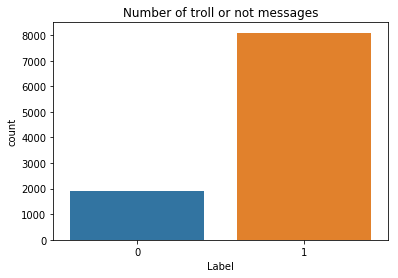

In [20]:
#Understand the distribution better
sns.countplot(df.isTroll)
plt.xlabel('Label')
plt.title('Number of troll or not messages')


In [26]:
X = df.message

Y = df.isTroll
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [27]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [28]:
def tokenizeMessages(messages):
    #TOKENIZING THE TEXT
    regexTokenizer = RegexpTokenizer(r'\w+')
    messages = messages.apply(regexTokenizer.tokenize)
    # delete Stop Words
    messages = messages.apply(lambda vec: [word for word in vec if word not in stopwords0])
    return messages

train_tokens = tokenizeMessages(X_train)
# test_tokens = tokenizeMessages(X_test)


In [29]:
alltrainingwords = [word for tokens in train_tokens for word in tokens]
trainingsentencelengths = [len(tokens) for tokens in train_tokens]
TRAININGVOCAB = sorted(list(set(alltrainingwords)))

print("%s words total, with a vocabulary size of %s" % (len(alltrainingwords), len(TRAININGVOCAB)))
print("Max sentence length is %s" % max(trainingsentencelengths))

70682 words total, with a vocabulary size of 12488
Max sentence length is 24


In [30]:
#WORD2VEC
word2vecpath = "./GoogleNews-vectors-negative300.bin.gz"

print("Loading W2V")
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vecpath, binary=True)
print("W2V Loaded")

def getaverageword2vec(tokenslist, vector, generatemissing=False, k=300):
    if len(tokenslist)<1:
        return np.zeros(k)
    if generatemissing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokenslist]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokenslist]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

#GETTING EMBEDDINGS
def getword2vecembeddings(vectors, messages, generatemissing=False):
    embeddings = messages.apply(lambda x: getaverageword2vec(x, vectors,
                                                                          generatemissing=generatemissing))
    return list(embeddings)

Loading W2V
W2V Loaded


In [31]:
#TRAIN EMBEDDING
trainingembeddings = getword2vecembeddings(word2vec, X_train, generatemissing=True)
tokenizer = Tokenizer(num_words=MAXVOCABSIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(X_train)
trainingsequences = tokenizer.texts_to_sequences(X_train)

trainwordindex = tokenizer.word_index
print('Found %s unique tokens.' % len(trainwordindex))

traincnndata = pad_sequences(trainingsequences, maxlen=MAXSEQLENGTH)

trainembeddingweights = np.zeros((len(trainwordindex)+1, EMBEDDINGDIM))
for word,index in trainwordindex.items():
    trainembeddingweights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDINGDIM)
print(trainembeddingweights.shape)

Found 13442 unique tokens.
(13443, 300)


In [32]:
testsequences = tokenizer.texts_to_sequences(X_test)
testcnndata = pad_sequences(testsequences, maxlen=MAXSEQLENGTH)

In [33]:
#DEFINING THE CNN
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Finally, we feed the output into a Sigmoid layer.
    # The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) 
    # for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [34]:
model = ConvNet(trainembeddingweights, MAXSEQLENGTH, len(trainwordindex)+1, EMBEDDINGDIM, False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     4032900     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 198, 128)     115328      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)    

In [35]:
#DEFINING CALLBACKS
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbackslist = [earlystopping]

In [36]:
#TRAINING THE NETWORK
hist = model.fit(traincnndata, Y_train, epochs=epochs, callbacks=callbackslist, validation_split=0.1, shuffle=True, batch_size=batchsize)

Instructions for updating:
Use tf.cast instead.
Train on 7650 samples, validate on 850 samples
Epoch 1/3
7650/7650 [==============================] - 37s 5ms/step - loss: 0.4528 - acc: 0.8000 - val_loss: 0.3681 - val_acc: 0.8082
Epoch 2/3
7650/7650 [==============================] - 34s 4ms/step - loss: 0.3301 - acc: 0.8250 - val_loss: 0.3150 - val_acc: 0.8506
Epoch 3/3
7650/7650 [==============================] - 33s 4ms/step - loss: 0.2921 - acc: 0.8620 - val_loss: 0.2999 - val_acc: 0.8776


In [37]:
ytest = model.predict(testcnndata, batch_size=1024, verbose=1)
yresults = model.evaluate(testcnndata, Y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(yresults[0],yresults[1]))

1500/1500 [==============================] - 3s 2ms/step
Test set
  Loss: 0.322
  Accuracy: 0.860


In [ ]:
#CREATING THE SUBMISSION.CSV FILE
# submissiondf = pd.DataFrame(columns=['id'] + labelnames)
# submissiondf['id'] = testcomments['id'].values 
# submissiondf[labelnames] = ytest 
# submissiondf.to_csv("./cnn_submission.csv", index=False)

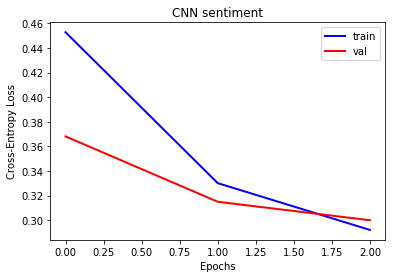

In [38]:
#GENERATING THE GRAPHS
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

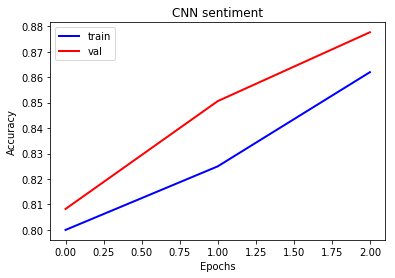

In [39]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

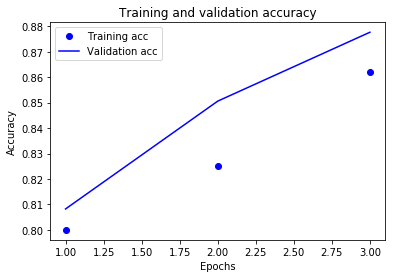

In [40]:
history_dict = hist.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.clf() # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()